# Проект "Рекомендация тарифов"

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами.
Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

<b>Цель исследования</b> - построить модель с максимально большим значением accuracy для задачи классификации, которая выберет подходящий тариф.
Предобработка данных не понадобится — вы её уже сделали.

Нужно довести долю правильных ответов по крайней мере до 0.75.
Проверить accuracy на тестовой выборке.

<b>Исходные данные</b> - предоставлены данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»).


Задачи
1. Изучение общей информации.
- данные загружены и изучены

2. Предобработка данных:
- не потребуется (уже проведена)

3. Провести исследовательский анализ данных:
- разбить исходные данные на три выборки: обучающую, валидационную (проверочную) и тестовую
- провести исследование качества моделей
    - Рассмотрено больше одной модели
    - Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - Написаны выводы по результатам исследования
- Проведено тестирование
- Удалось достичь accuracy не меньше 0.75

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Инструменты библиотеки и техники
**Python, pandas, numpy, seaborn, matplotlib, исследовательский анализ данных, основы машинного обучения**

## Файл с данными и изучение общей информации

In [1]:
import time as time
from tqdm import tqdm as tqdm
import warnings as warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output as clear_output

from sklearn.model_selection import train_test_split as train_test_split
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier
from sklearn.linear_model import LogisticRegression as LogisticRegression
from sklearn.metrics import accuracy_score as accuracy_score
from sklearn import tree as tree
from sklearn.tree import plot_tree as plot_tree

RANDOM_FIX_NUMBER = 12345 # значение для random_state

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

При просмотре содержимого файла с данными 'datasets/users_behavior.csv' установлено, что разделителем является пробельный символ.

In [2]:
import pandas as pd

try:
    df = pd.read_csv('datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

# посмотрим рандомные 10 строк
df.sample(10)

,calls,minutes,messages,mb_used,is_ultra
2733,94.0,596.13,63.0,20943.57,0
865,122.0,837.76,1.0,20197.07,1
2836,56.0,433.63,22.0,20869.68,0
2992,106.0,687.91,29.0,16631.86,0
742,136.0,999.09,84.0,23116.46,1
3151,84.0,622.60,32.0,16318.74,0
2323,101.0,731.07,125.0,20223.02,0
1021,108.0,789.17,12.0,32670.36,1
618,65.0,490.26,76.0,30307.39,1
2453,77.0,507.69,29.0,15418.55,0


### Общая информация о датафрейме

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Набор данных состоит из 3214 строк и 5 столбцов. Все столбцы являются числовыми признаками.

Посмотрим описательную статистику:

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


### Общая гистограмма для всех числовых столбцов датафрейма

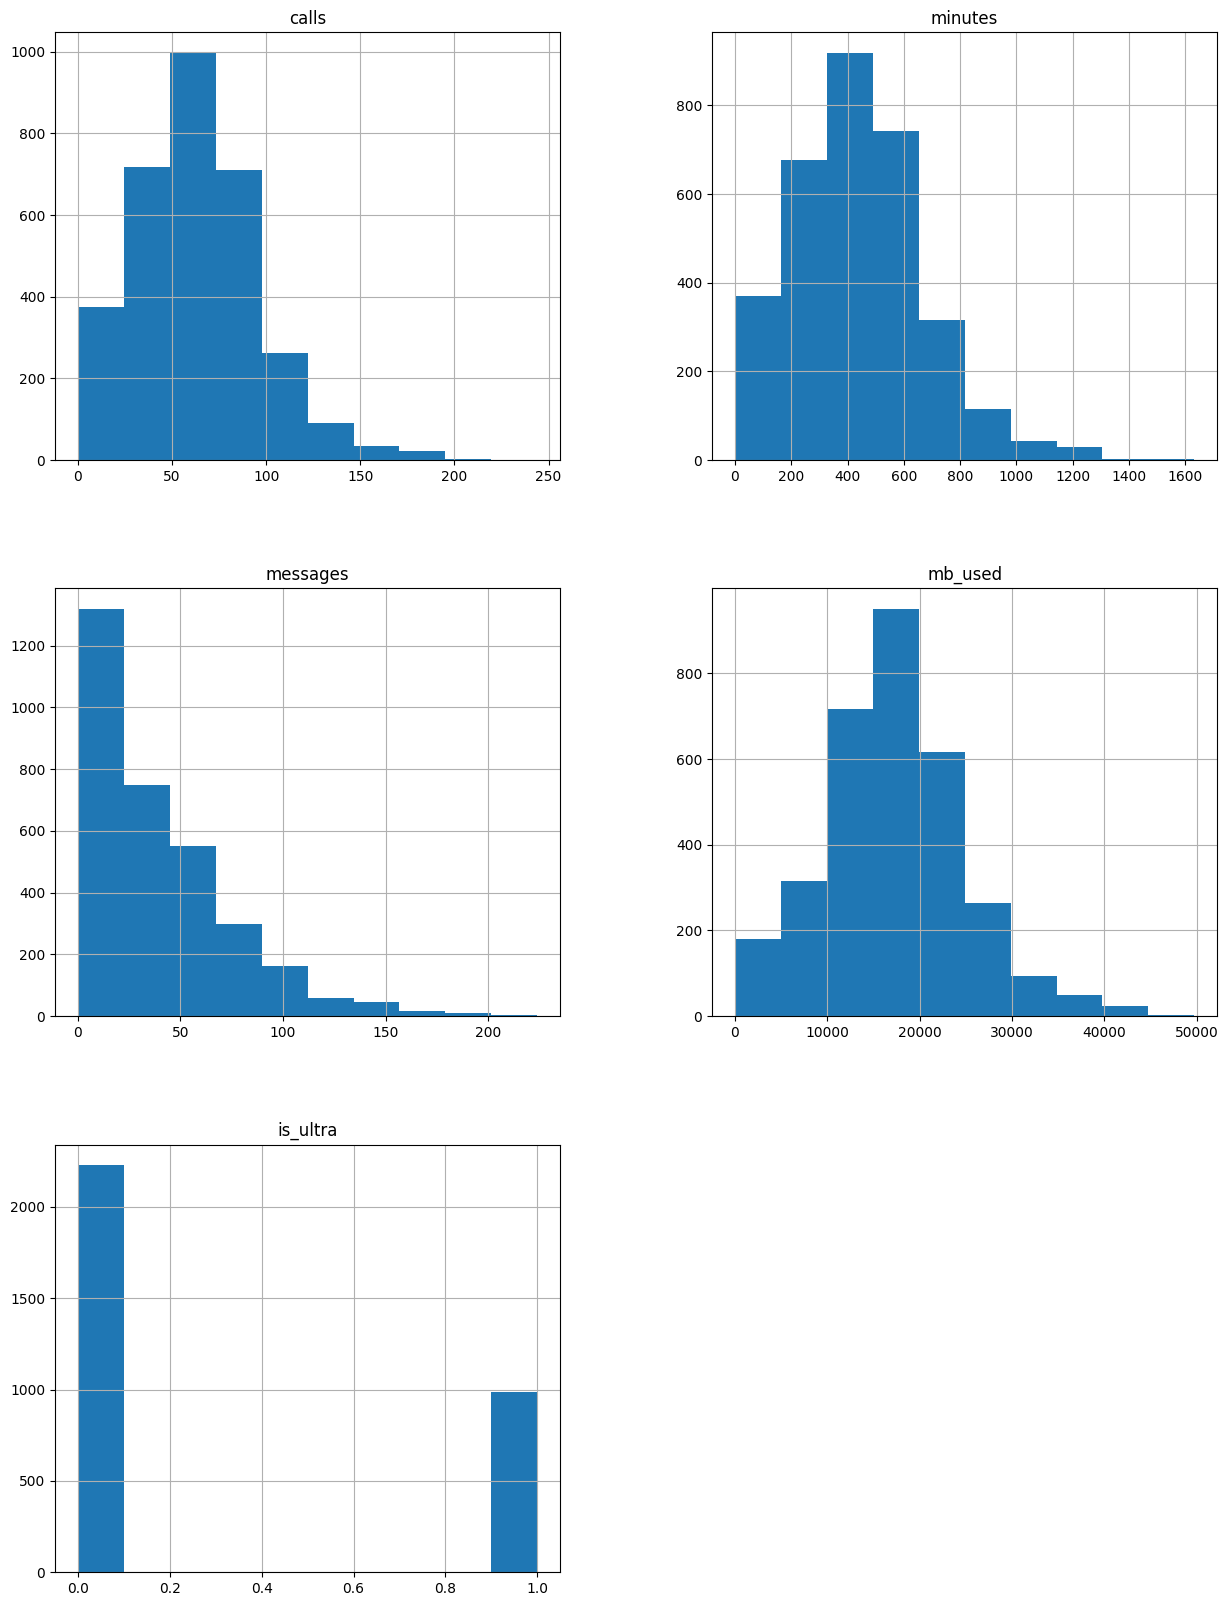

In [5]:
# Посмотрим на гистограммы числовых признаков
df.hist(figsize=(15, 20));

Как видно из графиков в столбцах "calls", "minutes" и "messages" присутствуют нулевые значения, графики смещены влево. Посмотрим на данные с нулевыми значениями в столбцах "calls" и "minutes"

In [6]:
df.loc[((df['calls']==0)
        &(df['minutes']==0)
        )]

,calls,minutes,messages,mb_used,is_ultra
54,0.0,0.0,33.0,14010.33,1
247,0.0,0.0,35.0,16444.99,1
264,0.0,0.0,21.0,19559.55,0
351,0.0,0.0,8.0,35525.61,1
390,0.0,0.0,25.0,19088.67,1
484,0.0,0.0,191.0,32448.02,1
551,0.0,0.0,24.0,18701.54,1
647,0.0,0.0,30.0,10236.20,1
769,0.0,0.0,32.0,17206.44,0
884,0.0,0.0,180.0,32045.73,1


Заметим, что данные по сообщениям и интернет-трафику в этих строках присутствуют.
Вероятнее всего на месте нулевых значений были пропуски и их заменили на ноль.
Фактически в нашей задаче эти данные даже не бесполезны, а вредны. Т.к. они будут лишь запутывать модель, которая будет пытаться обобщить данные.

Посмотрим на диаграмму размаха признака `calls`

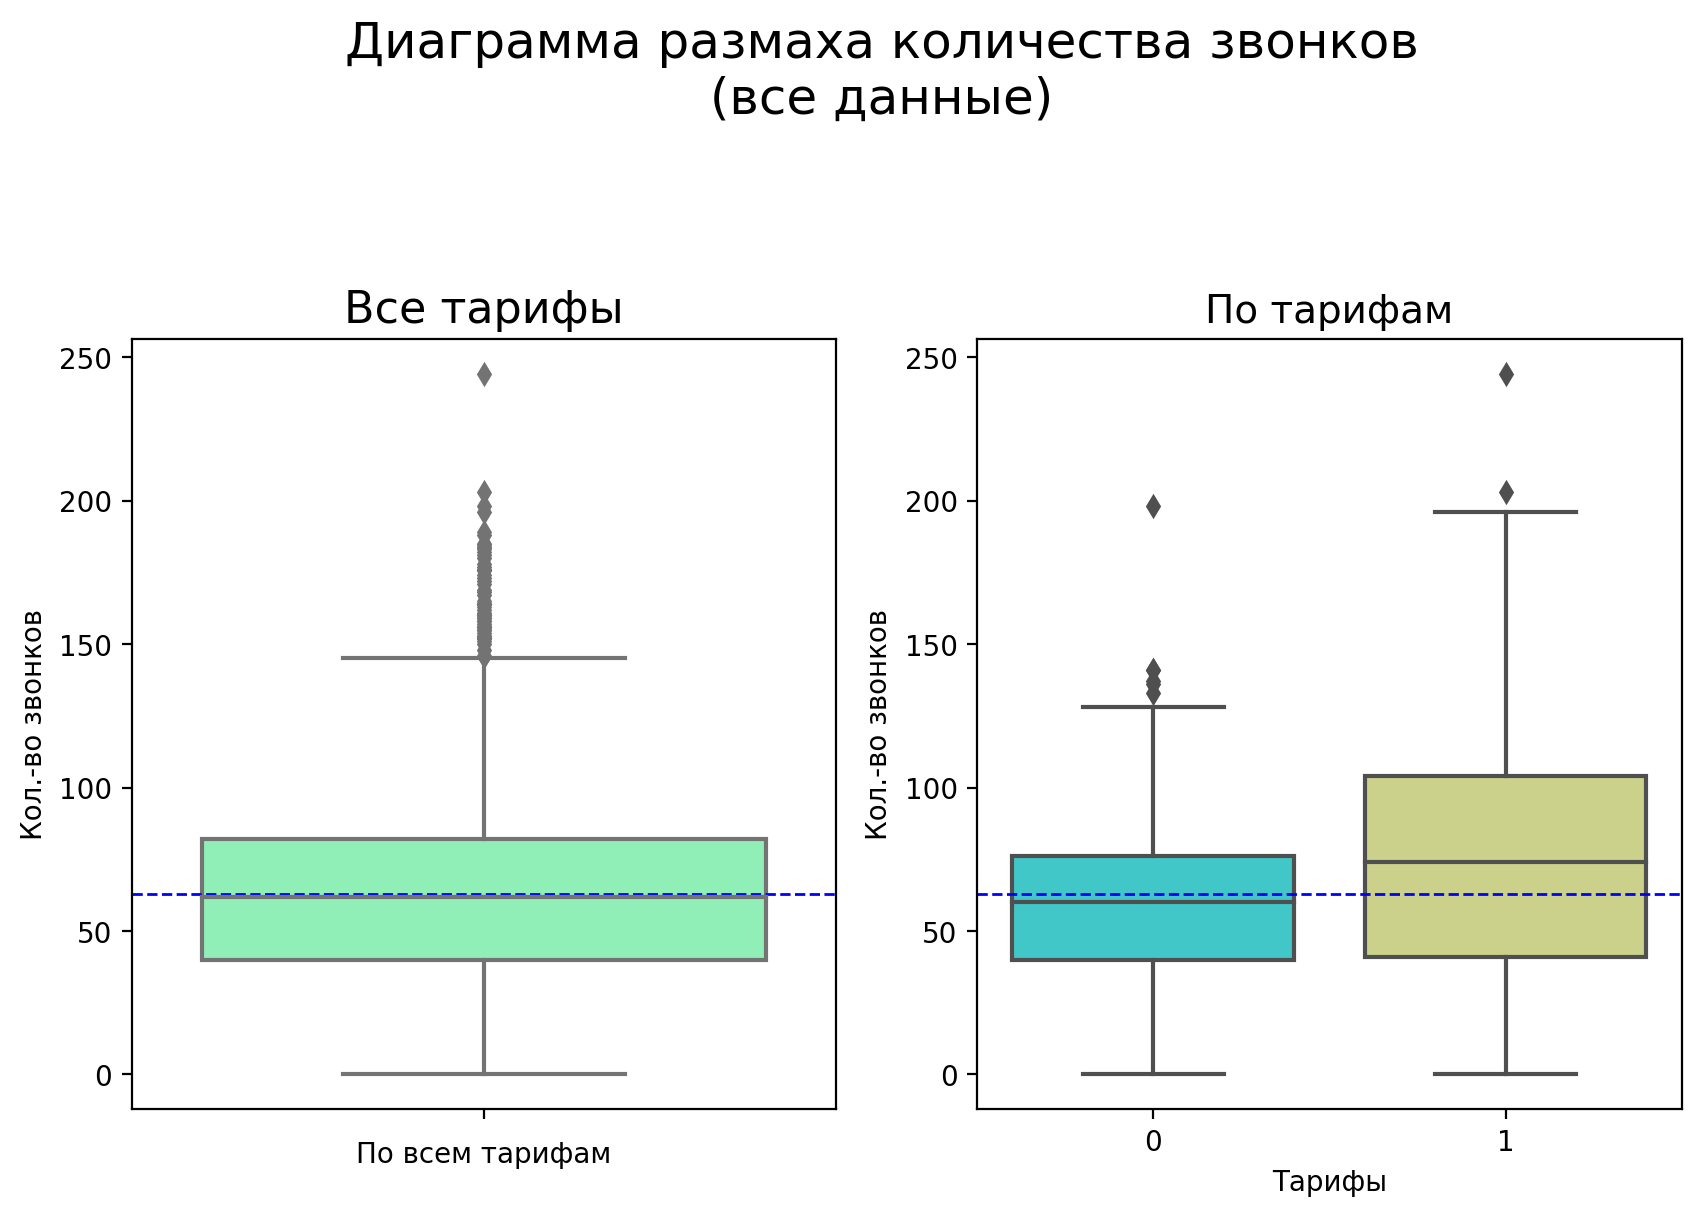

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=200)
fig.suptitle('Диаграмма размаха количества звонков\n(все данные)',
             y = 1.2,
             fontsize = 18)
sns.boxplot(ax=ax1, y="calls", data=df, palette='rainbow', hue="is_ultra")
ax2.set_width = 20
ax1.set_title('Все тарифы', fontsize = 16)
ax1.set(xlabel='По всем тарифам', ylabel='Кол.-во звонков')
ax1.axhline(y=63, color='b', label='median', linestyle='--', linewidth=1)

sns.boxplot(ax=ax2, x="is_ultra", y="calls", data=df, palette='rainbow')
ax2.set_title('По тарифам', fontsize = 14)
ax2.set(xlabel='Тарифы', ylabel='Кол.-во звонков')
ax2.axhline(y=63, color='b', label='median', linestyle='--', linewidth=1)

Медиана находится на уровне 63.0, объекты содержат количество звонков равные 0 минут, а также выбивающиеся значения > 148. Вероятнее всего на месте нулевых значений были пропуски и их заменили на ноль. Оценим их количество.

Всего: 3214, нулевых значений: 40 (1.2%)


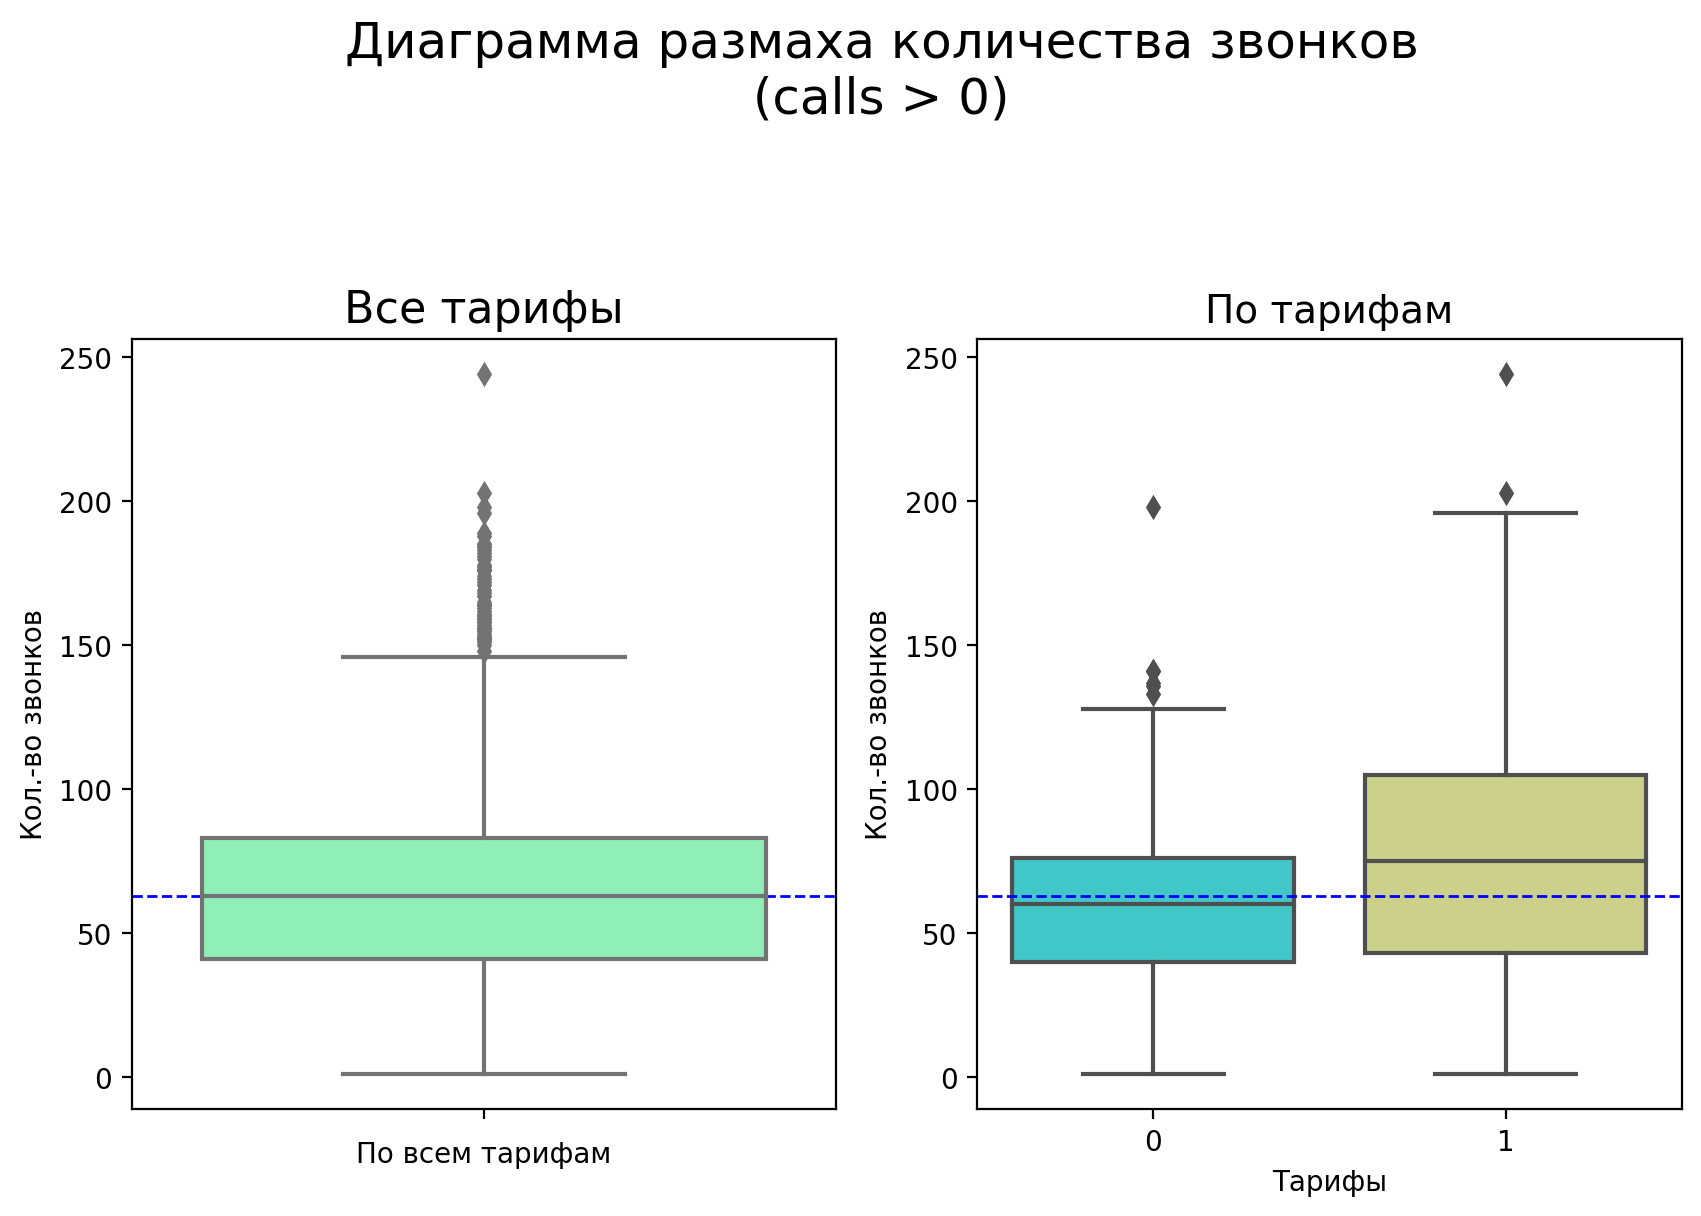

In [8]:
accepted_calls = df.query('calls > 0')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=200)
fig.suptitle('Диаграмма размаха количества звонков\n(calls > 0)',
             y = 1.2,
             fontsize = 18)
sns.boxplot(ax=ax1, y="calls", data=accepted_calls, palette='rainbow', hue="is_ultra")
ax2.set_width = 20
ax1.set_title('Все тарифы', fontsize = 16)
ax1.set(xlabel='По всем тарифам', ylabel='Кол.-во звонков')
ax1.axhline(y=63, color='b', label='median', linestyle='--', linewidth=1)

sns.boxplot(ax=ax2, x="is_ultra", y="calls", data=accepted_calls, palette='rainbow')
ax2.set_title('По тарифам', fontsize = 14)
ax2.set(xlabel='Тарифы', ylabel='Кол.-во звонков')
ax2.axhline(y=63, color='b', label='median', linestyle='--', linewidth=1)

all_calls_amount = len(df)
accepted_calls_amount = len(accepted_calls)
missed_calls_amount = all_calls_amount - accepted_calls_amount
print(f'Всего: {all_calls_amount}, нулевых значений: {missed_calls_amount} ({round(missed_calls_amount * 100 / all_calls_amount, 1)}%)')

Около 1% - это не окажет заметного влияния на исследование.

Проверим адекватность значений длительности звонков `minutes`. Для этого построим диаграмму размаха.

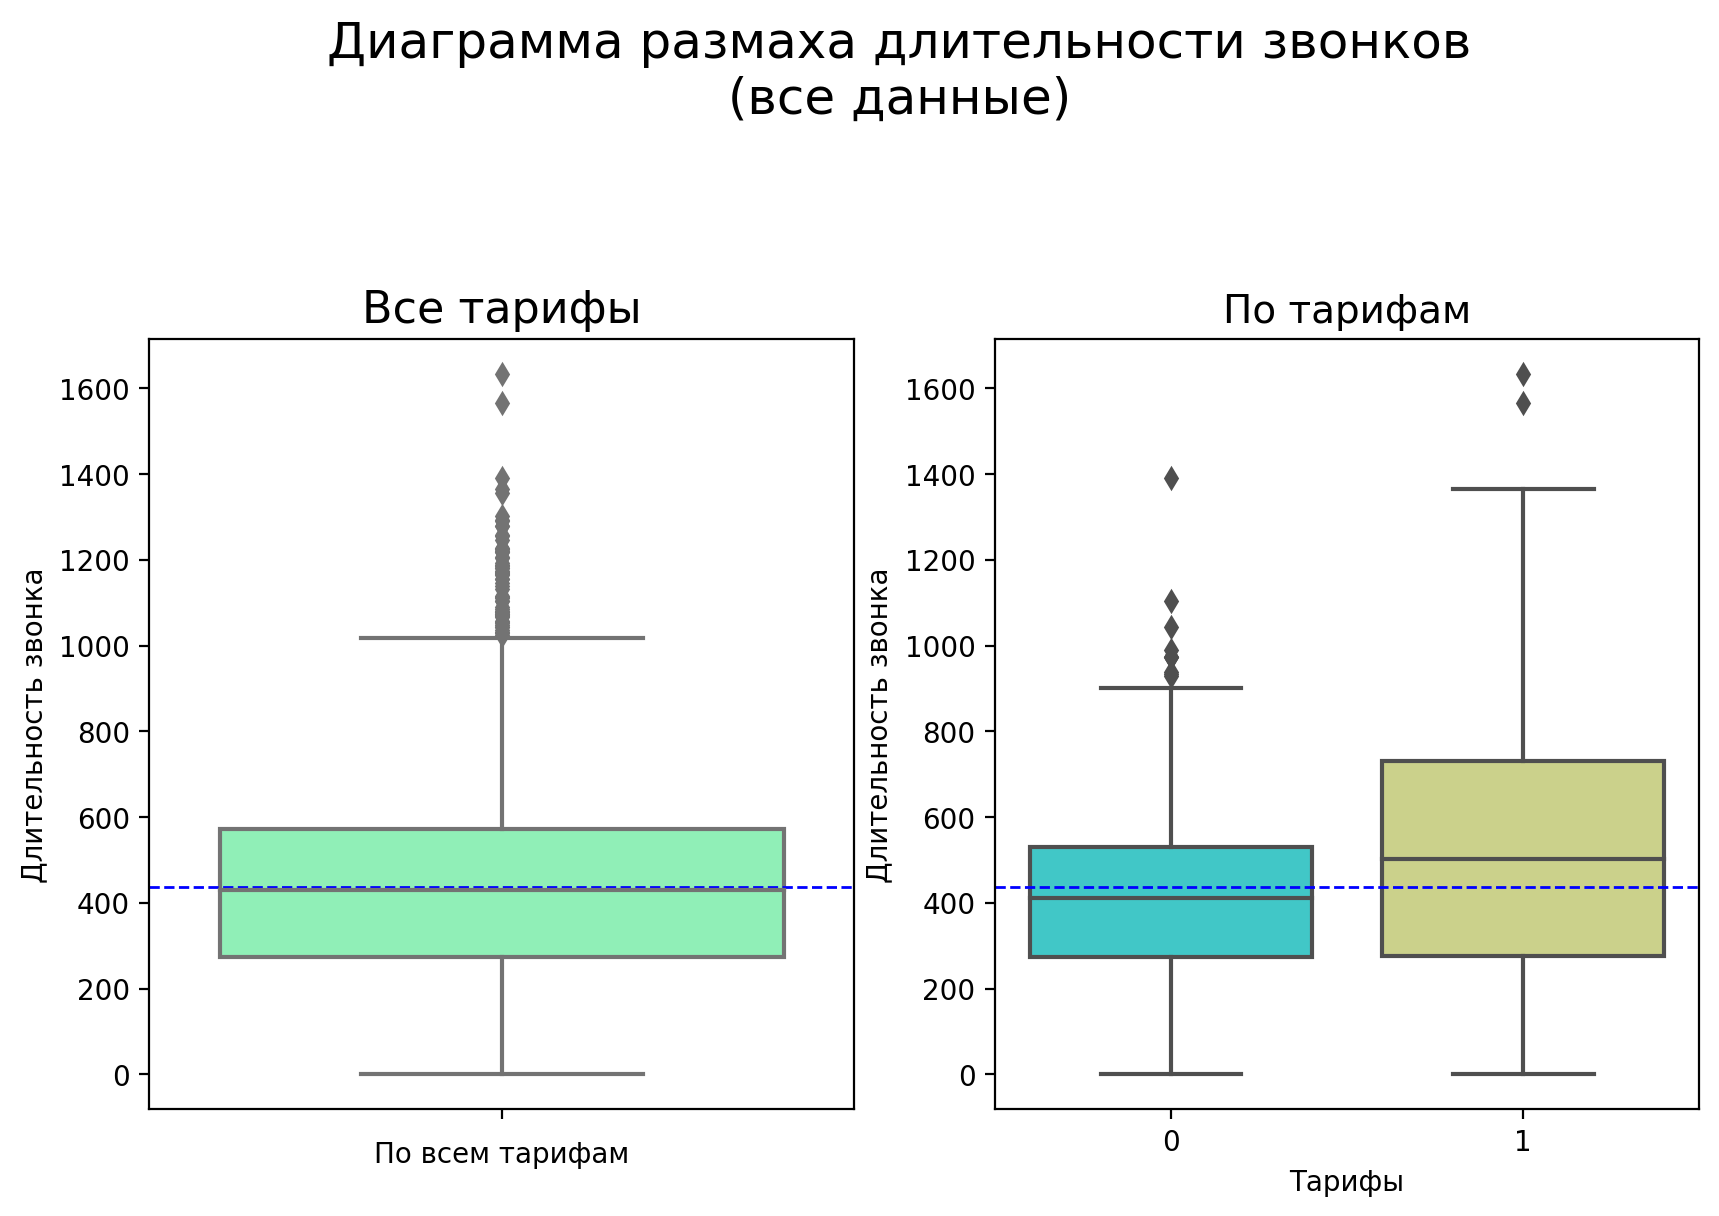

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=200)
fig.suptitle('Диаграмма размаха длительности звонков\n(все данные)',
             y = 1.2,
             fontsize = 18)
sns.boxplot(ax=ax1, y="minutes", data=df, palette='rainbow', hue="is_ultra")
ax2.set_width = 20
ax1.set_title('Все тарифы', fontsize = 16)
ax1.set(xlabel='По всем тарифам', ylabel='Длительность звонка')
ax1.axhline(y=438, color='b', label='median', linestyle='--', linewidth=1)

sns.boxplot(ax=ax2, x="is_ultra", y="minutes", data=df, palette='rainbow')
ax2.set_title('По тарифам', fontsize = 14)
ax2.set(xlabel='Тарифы', ylabel='Длительность звонка')
ax2.axhline(y=438, color='b', label='median', linestyle='--', linewidth=1)

Медиана находится на уровне 438.2 минут, есть звонки по 0 минут, а также выбивающиеся звонки (более 1100 минут). В целом, данные скошены влево. Проверим, что это не вызвано способом отметки пропущенных звонков, и заодно определим их количество.

Всего звонков: 3214, пропущенных звонков: 40 (1.2%)


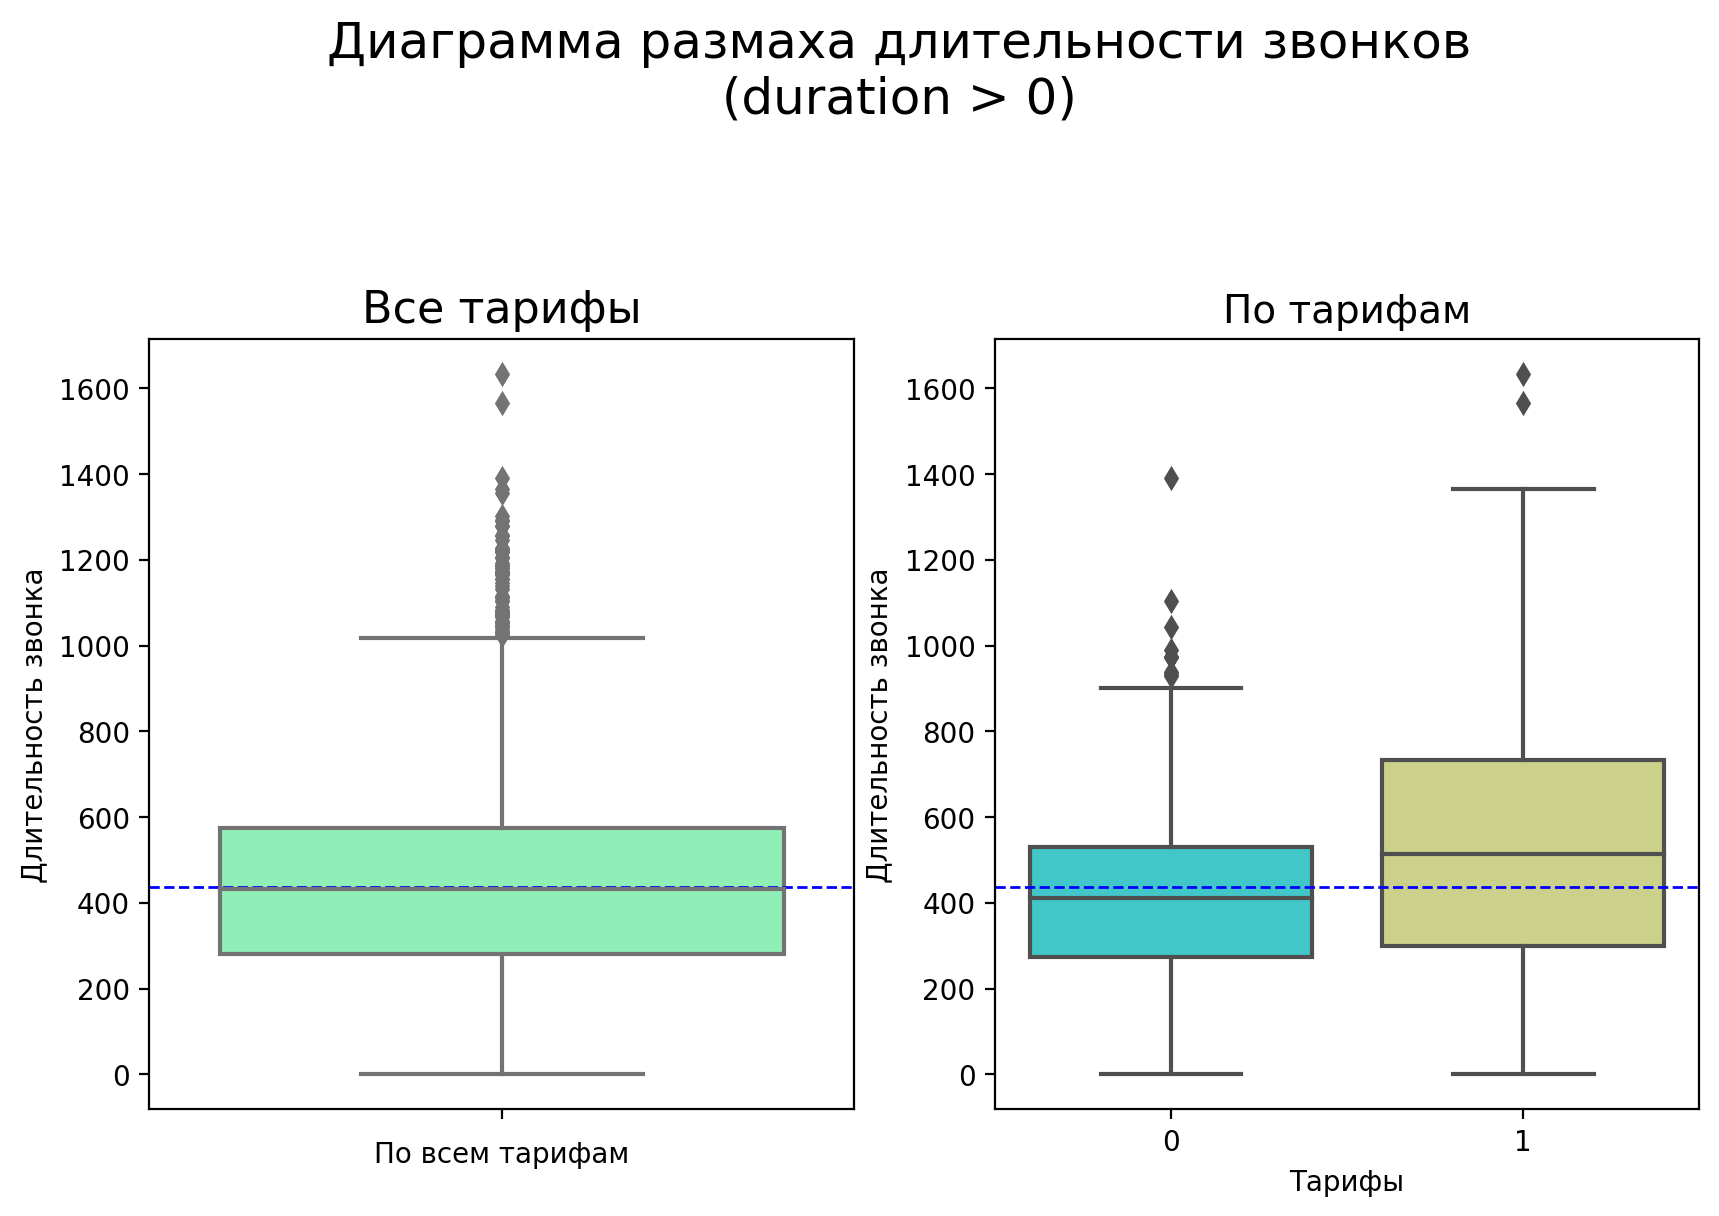

In [10]:
accepted_calls = df.query('minutes > 0')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=200)
fig.suptitle('Диаграмма размаха длительности звонков\n(duration > 0)',
             y = 1.2,
             fontsize = 18)
sns.boxplot(ax=ax1, y="minutes", data=accepted_calls, palette='rainbow', hue="is_ultra")
ax2.set_width = 20
ax1.set_title('Все тарифы', fontsize = 16)
ax1.set(xlabel='По всем тарифам', ylabel='Длительность звонка')
ax1.axhline(y=438, color='b', label='median', linestyle='--', linewidth=1)

sns.boxplot(ax=ax2, x="is_ultra", y="minutes", data=accepted_calls, palette='rainbow')
ax2.set_title('По тарифам', fontsize = 14)
ax2.set(xlabel='Тарифы', ylabel='Длительность звонка')
ax2.axhline(y=438, color='b', label='median', linestyle='--', linewidth=1)

all_calls_amount = len(df)
accepted_calls_amount = len(accepted_calls)
missed_calls_amount = all_calls_amount - accepted_calls_amount
print(f'Всего звонков: {all_calls_amount}, пропущенных звонков: {missed_calls_amount} ({round(missed_calls_amount * 100 / all_calls_amount, 1)}%)')

Около 1% всех звонков - пропущенные, это не окажет заметного влияния на исследование.

Проверим адекватность значений использованных мегабайт. Для этого построим диаграмму размаха.

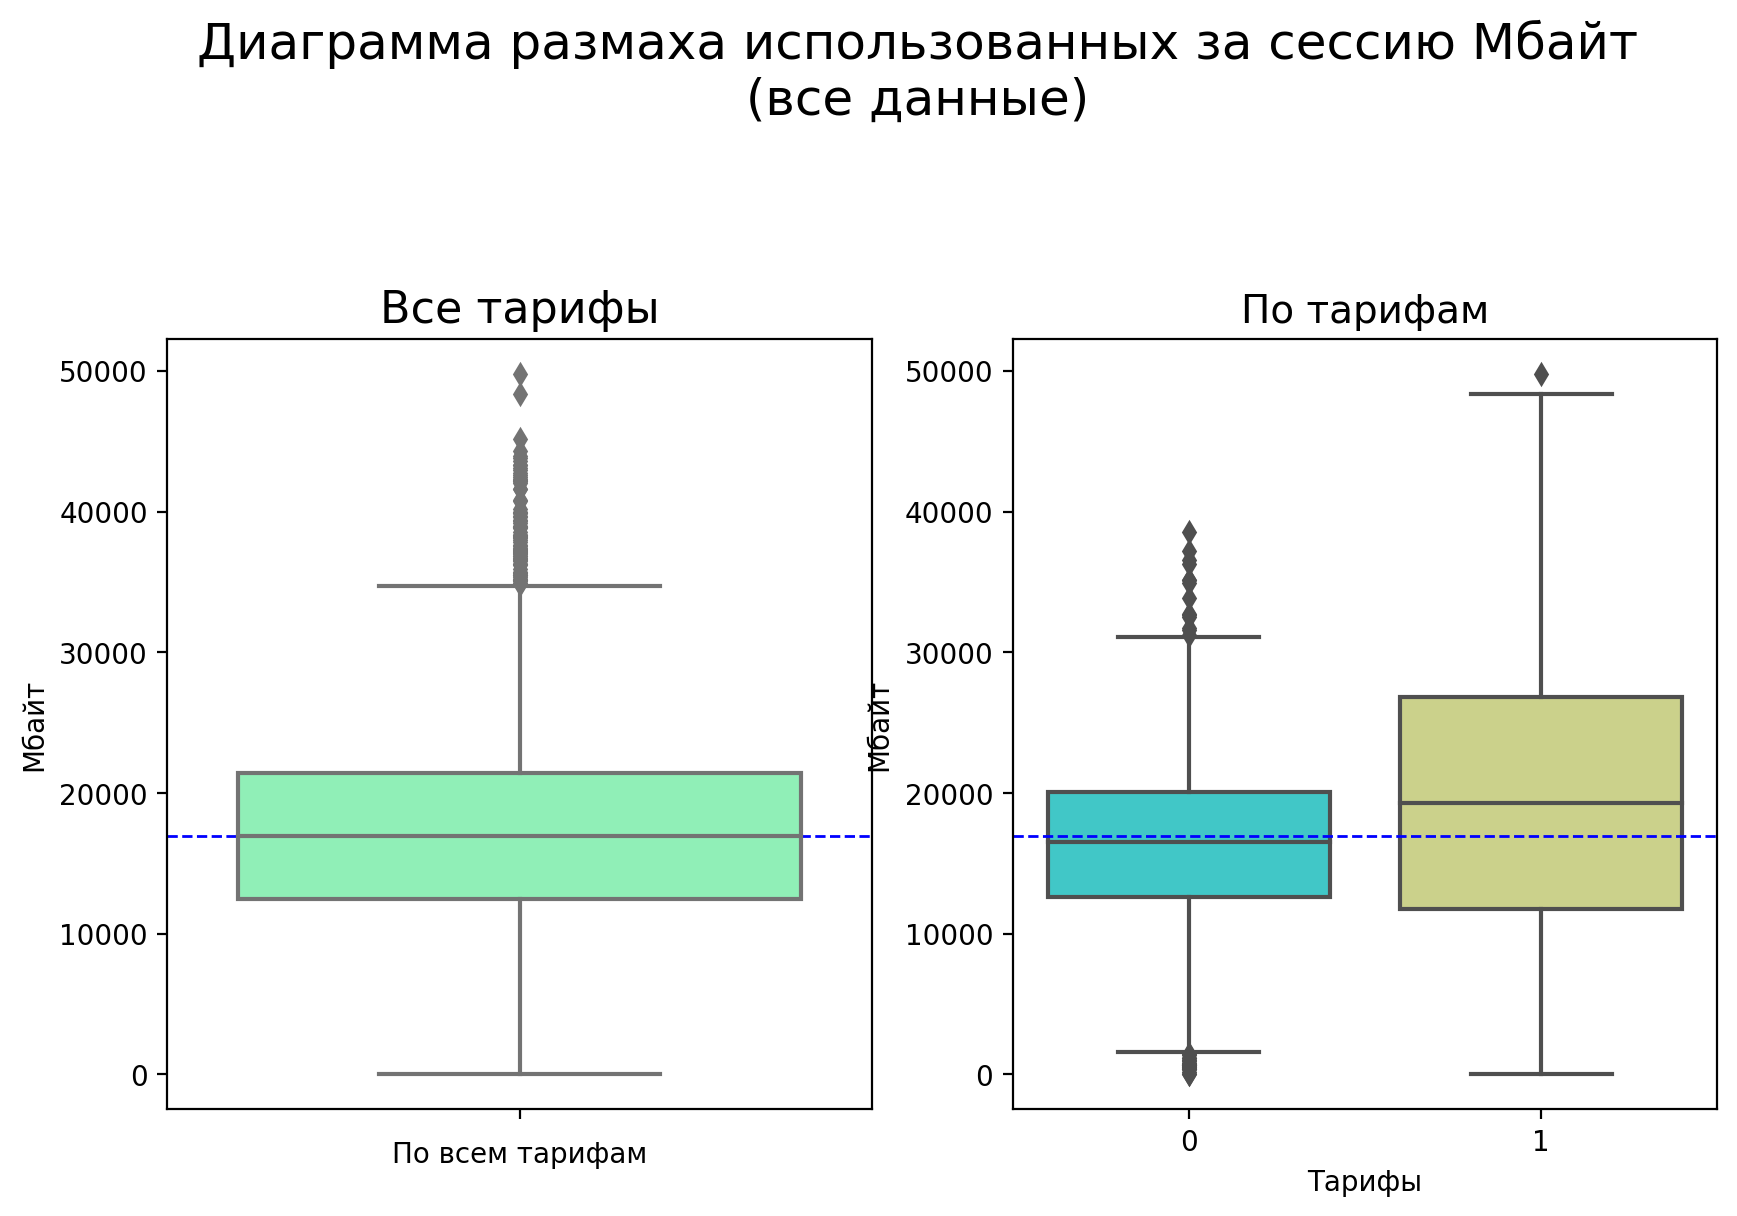

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=200)
fig.suptitle('Диаграмма размаха использованных за сессию Мбайт\n(все данные)',
             y = 1.2,
             fontsize = 18)
sns.boxplot(ax=ax1, y="mb_used", data=df, palette='rainbow', hue="is_ultra")
ax2.set_width = 20
ax1.set_title('Все тарифы', fontsize = 16)
ax1.set(xlabel='По всем тарифам', ylabel='Мбайт')
ax1.axhline(y=16943, color='b', label='median', linestyle='--', linewidth=1)

sns.boxplot(ax=ax2, x="is_ultra", y="mb_used", data=df, palette='rainbow')
ax2.set_title('По тарифам', fontsize = 14)
ax2.set(xlabel='Тарифы', ylabel='Мбайт')
ax2.axhline(y=16943, color='b', label='median', linestyle='--', linewidth=1)

В данных есть сессии, где использовано 0 Мбайт. Это выглядит подозрительно. Посмотрим долю таких записей

In [12]:
print(len(df.query('mb_used == 0')) / len(df))

0.003422526446795271


Это несущественно.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Разделим таблицу пользователей на 2 части по используемому тарифу. Посмотрим, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Построим гистограммы и опишем распределения.

Помесячные траты пользователей в зависимости от тарифа


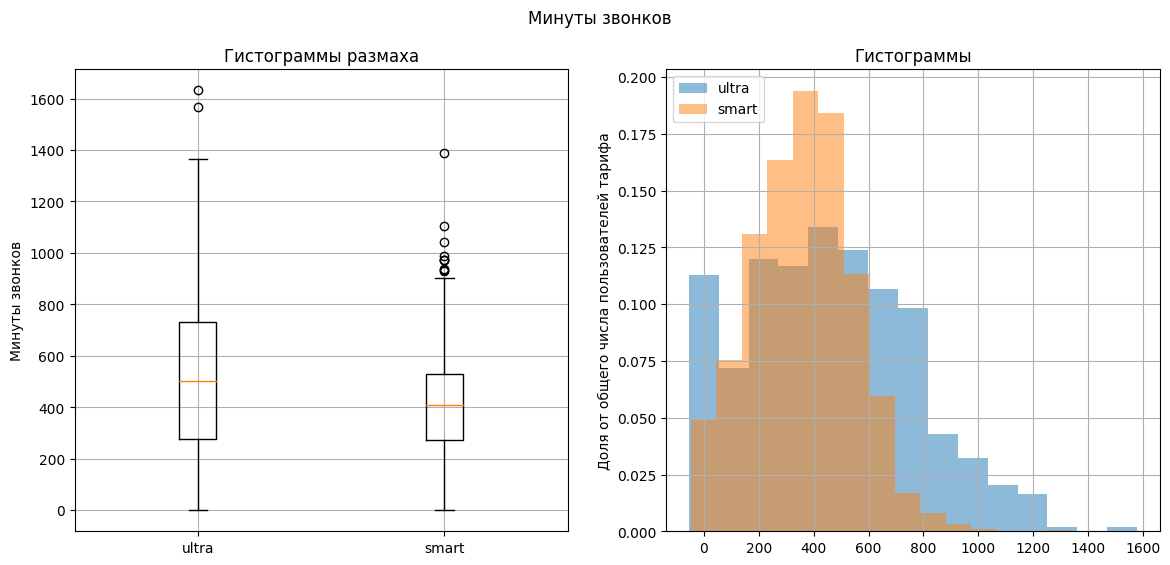

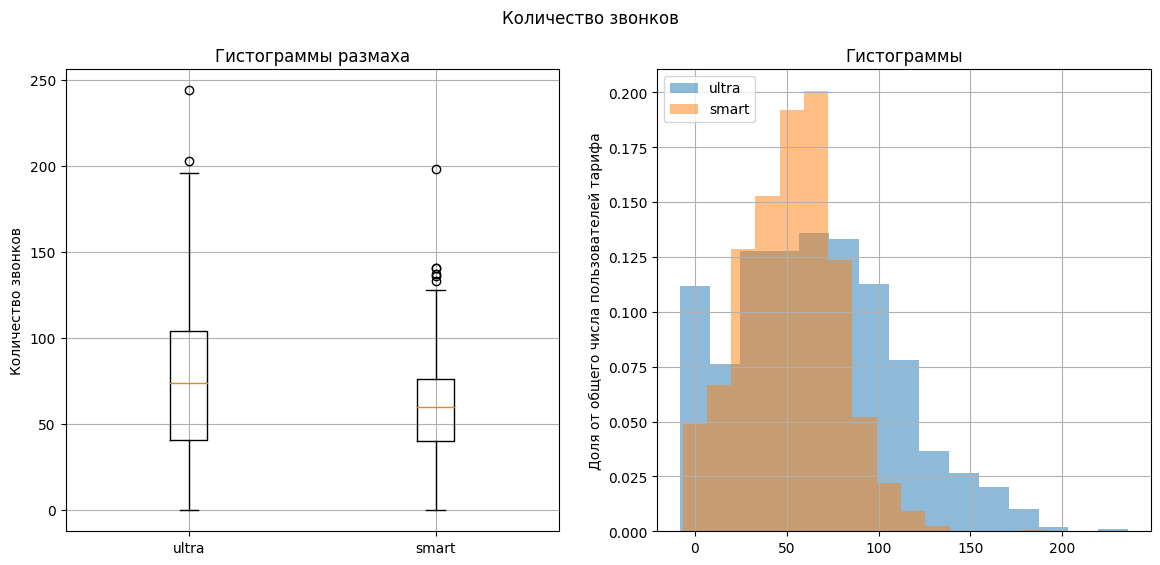

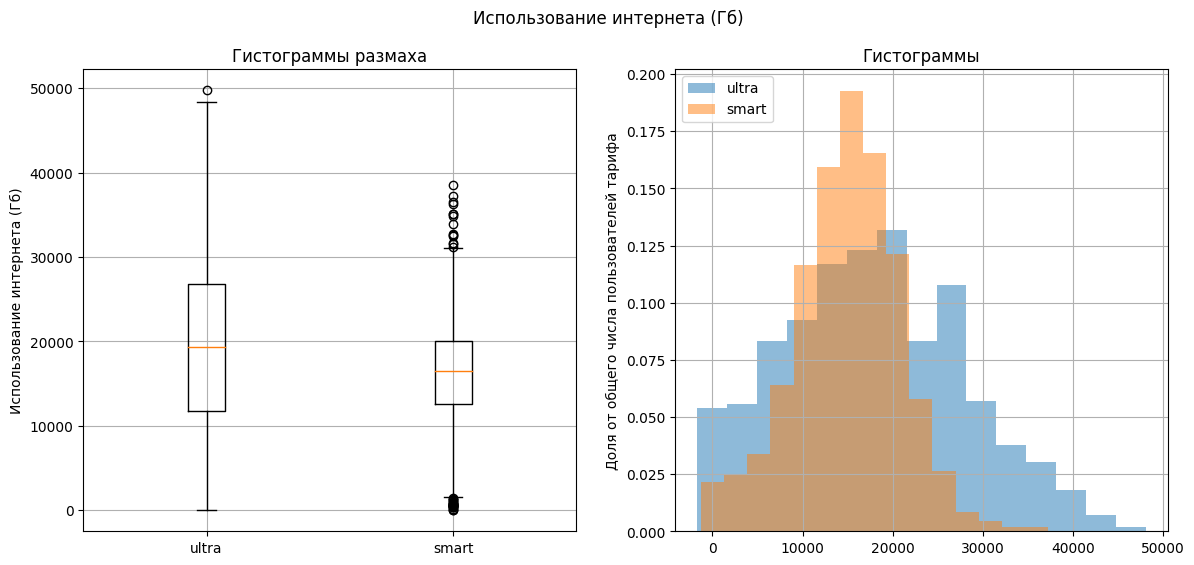

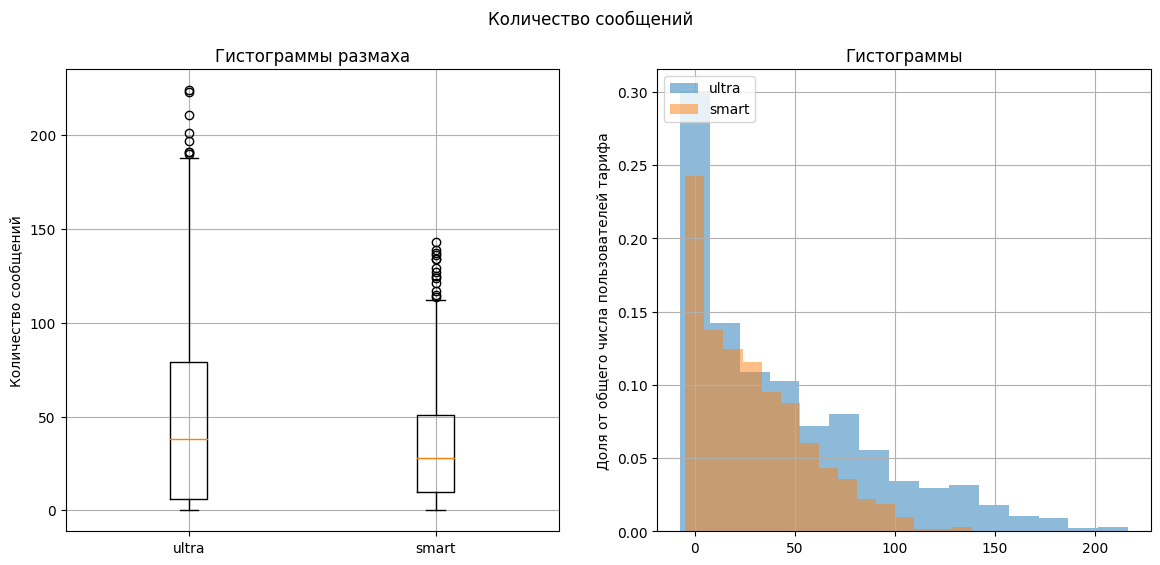

In [13]:
ultra_users_stats = df[df['is_ultra'] == 1]
smart_users_stats = df[df['is_ultra'] == 0]

print('Помесячные траты пользователей в зависимости от тарифа')
for column_name, title in (
    ('minutes', 'Минуты звонков'), 
    ('calls', 'Количество звонков'), 
    ('mb_used', 'Использование интернета (Гб)'), 
    ('messages', 'Количество сообщений')
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title)

    ax1.boxplot([ultra_users_stats[column_name], smart_users_stats[column_name]], labels = ['ultra', 'smart'])
    ax1.set_title('Гистограммы размаха')
    ax1.set_ylabel(title)
    ax1.grid()
    
    n_bins=15
    
    hist, bins = np.histogram(ultra_users_stats[column_name], bins=n_bins)
    ax2.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha = 0.5, label='ultra')
    
    hist, bins = np.histogram(smart_users_stats[column_name], bins=n_bins)
    ax2.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha = 0.5, label='smart')

    ax2.legend(loc='upper left')
    ax2.set_title('Гистограммы')
    ax2.set_ylabel('Доля от общего числа пользователей тарифа')
    ax2.grid()

Выводы:

- пользователи тарифа «Ультра» используют в общем бОльшие объемы услуг в сравнении с пользователями, которые используют тариф «Смарт» (медианы стоят выше, и на гистограммах бОльшие доли расположены дальше).

- Межквартильные размахи по тарифу «Ультра» (расстояние между первым и третьим квартилем, размер "ящика") больше, то есть данные разбросаны сильнее. Пользователи могут использовать как сравнительно малые (в пределах данного тарифа), так и сравнительно большие объемы услуг. По тарифу «Смарт» эти данные более скученные, то есть поведение пользователей этого тарифа более одинаково.

- соответствующие распределения минут звонков и объема интернет-трафика для обоих тарифов напоминают нормальные. "Колокол" для тарифа «Смарт» более высокий - данные пользователей тарифа «Смарт» более скученные.

- Гистограммы количества отправленных сообщений отличаются от остальных: они сильно скошены влево, то есть большинство пользователей обоих тарифов используют немного сообщений (при этом в тарифе «Ультра» выбросы все же распространяются дальше, в сравнении с тарифом «Смарт»). Видимо, сказывается влияние социальных сетей и интернет-мессенджеров: общение все больше переходит туда.

Посмотрим на статистические данные в цифрах: подсчитаем квартилили, средние и стандартные отклонения по рассматриваемым показателям для каждого тарифа.

In [14]:
print('Тариф "Ультра"')
ultra_users_stats[['minutes', 'calls', 'mb_used', 'messages']].describe()

Тариф "Ультра"


,minutes,calls,mb_used,messages
count,985.000000,985.000000,985.000000,985.000000
mean,511.224569,73.392893,19468.823228,49.363452
std,308.031100,43.916853,10087.178654,47.804457
min,0.000000,0.000000,0.000000,0.000000
25%,276.030000,41.000000,11770.280000,6.000000
50%,502.550000,74.000000,19308.010000,38.000000
75%,730.050000,104.000000,26837.720000,79.000000
max,1632.060000,244.000000,49745.730000,224.000000


In [15]:
print('Тариф "Смарт"')
smart_users_stats[['minutes', 'calls', 'mb_used', 'messages']].describe()

Тариф "Смарт"


,minutes,calls,mb_used,messages
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,405.942952,58.463437,16208.466949,33.384029
std,184.512604,25.939858,5870.498853,28.227876
min,0.000000,0.000000,0.000000,0.000000
25%,274.230000,40.000000,12643.050000,10.000000
50%,410.560000,60.000000,16506.930000,28.000000
75%,529.510000,76.000000,20043.060000,51.000000
max,1390.220000,198.000000,38552.620000,143.000000


Выводы, основанные на графиках, подтверждаются: пользователи тарифа «Смарт» (по среднему и квартилям), тратям меньшие объемы услуг по сравнению с полтзователями тарифа «Ультра», а стандартные отклонения всем рассматриваемым услугам выше у пользователей тарифа «Ультра», то есть разброс этих данных выше.

Вспомним, что записей о пользователях, использующих тариф «Смарт», примерно в 2 раза больше, чем записей о пользователях, использующих тариф «Ультра». Более высокие показатели стандартного отклонения можно связать с этим. Однако структурные характеристики (например, межквартильный размах) приводят к таким же выводам.

Посмотрим на взаимосвязи признаков.

Выделим признаки в отдельный датасет, построим график матрицы рассеяния и вычислим коэффициент корреляции между признаками.

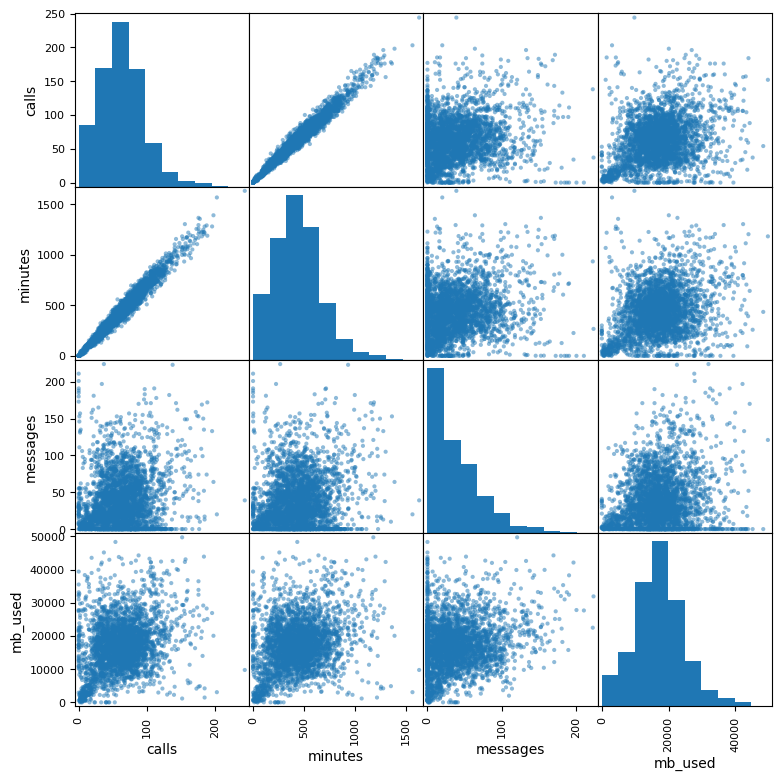

In [16]:
df_features = df.copy()

# удаляем целевой признак
del df_features['is_ultra']

# строим матрицу рассеяния между признаками
pd.plotting.scatter_matrix(df_features, figsize=(9, 9))

plt.show()

In [17]:
# строим матрицу корреляции между признаками
df_features.corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


Посмотрим их еще и на heatmap:

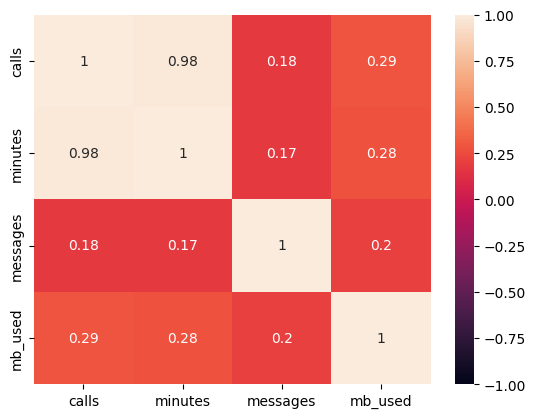

In [18]:
_ = sns.heatmap(df_features.corr(), vmax=1, vmin=-1, annot=True)

Наблюдается сильная прямая взаимосвязь между количеством совершенных звонков и количеством использованных минут, коэффициент корреляции 0,98. Это логично.

Но эта пара признаков является избыточной, т.к. сильно коррелирует друг с другом. Это явление носит название мультиколлинеарности. Удаление одной переменной в таких парах признаков часто помогает модели обобщать и быть более интерпретируемой.

В связи с вышесказанным:
- Из пары сильно коррелирующих признаков удалим признак "calls". Количество звонков не является определяющим параметром тарифа, а остальные признаки являются и ограничения по их использованию входят в пакет услуг тарифа.
- Удалим из таблицы все строки у которых количество использованных минут равно нулю. Так модель вернее определит закономерности между признаками.

Примечание:
Действительно присутствует мультиколлинеарность. И действительно можно удалить, но на самом деле всё так проблемно:

- в логистической, и в линейной регрессиях реализована регуляризация, которая решает проблему мультиколлинеарности признаков. "Деревянные" модели (RF, DT) устойчивы к мультиколлинеарности, а кластеризация тоже почти не зависит от линейных зависимостей. Получается, избавляться от мультиколлинеарности, чтобы не переобучаться не обязательно.    
    
- интерпретируемость линейной модели (по коэффициентам судим как признаки влияют на таргет), - тут мультиколлинеарность надо убирать.

Так что получается что в нашем случае убирать мультиколлинеарность имеет смысл только если мы захотим посмотреть как конкретно признаки влияют на таргет.

In [19]:
del df['calls']
df = df.query('minutes > 0')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3174 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   minutes   3174 non-null   float64
 1   messages  3174 non-null   float64
 2   mb_used   3174 non-null   float64
 3   is_ultra  3174 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 124.0 KB


## Выводы

Был проведен предварительный анализ поведения клиентов на небольшой выборке клиентов.

В таблице даны 3174 строк и 4 столбца. Все столбцы являются числовыми признаками.
Данные представлены типами float и int. Предобработка данных не потребуется (представленные данные уже предобработаны).

75% данных представляют тариф "Смарт", 25% - представляют тариф "Ультра".

В результате анализа выяснились средние показатели этой выборки:
- Пользователи тарифа "Ультра":
    - тратят 503 минут звонков,
    - отправляют 38 сообщений,
    - используют 74 МБ интернета.
-
- Пользователи тарифа "Смарт":
    - тратят 411 минут звонков,
    - отправляют 28 сообщений,
    - используют 60 МБ интернета.

В целом, разброс значений данных у пользователей тарифа "Смарт" меньше, чем у пользователей тарифа "Ультра".

## Разбейте данные на выборки

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3 : 1 : 1 (60% : 20% : 20%).

В `sklearn` для этого предусмотрена функция `train_test_split`.
Т.к. нам нужно разделить датасет на три части, то деление будет происходить в два этапа.

1. Сначала разделим на обучающий набор и проверочный в соотношении 60%:40%.
2. Затем проверочный набор поделим пополам на валидационный набор и тестовый.

Зададим параметр random_state чтобы можно было воспроизвести это псевдослучайное разбиение данных.

In [21]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Стратифицируем данные в соответствии с распределением по классам в target (это признак `is_ultra`).
Мы стремимся добиться наиболее оптимального (из возможных, с учетом того, что 75% данных представляют тариф "Смарт", 25% - представляют тариф "Ультра") разделений данных, чтобы алгоритм имел равные возможности для изучения признаков каждого из представленных классов и последующего тестирования результатов обучения, на равном числе экземпляров каждого класса.
Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым.

In [22]:
features_train, features_check, target_train, target_check = train_test_split(features,
                                                                              target,
                                                                              train_size=0.4,
                                                                              random_state=12345,
                                                                              stratify=target)

In [23]:
features_valid, features_test, target_valid, target_test = train_test_split(features_check,
                                                                             target_check,
                                                                             train_size=0.5,
                                                                             random_state=12345,
                                                                             stratify=target_check)

In [24]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [889 380]
Количество строк в target_valid по классам: [667 285]
Количество строк в target_test по классам: [667 286]


In [25]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(1269, 3)
(952, 3)
(953, 3)


## Исследуйте модели

В качестве целевого признака выступает столбец `is_ultra``. Т.к. в нем отражено какой тариф использует клиент, Смарт или Ультра, следовательно этот признак является категориальным. Следовательно нам необходимо решить задачу классификации, а точнее бинарной классификации (т.к. целевых значений всего два).

Чтобы предложить клиенту новый тариф мы должны предположить как работают взаимосвязи признаков у пользователей этих новых тарифов. На основании этих предположений сможем предсказать какой тариф предложить клиенту. Если эти предсказания соответсвуют реальности, то мы на верном пути и наши предположения верны.
Такой подход называется моделированием, а сами предположения и способы предсказания — моделями машинного обучения.

В процессе моделирования будем использовать следующие модели машинного обучения:

- Решающее дерево
- Случайный лес
- Логистическая регрессия

У "Решающего дерева" и "Случайного леса" есть гиперпараметры, меняя которые можно подобрать наилучшую модель.

У "Решающего дерева" это максимальная глубина дерева max_depth.

У "Случайного леса" к максимальной глубине добавляется еще один гиперпараметр количество деревьев n_estimators.

Каждую модель обучим на обучающем наборе и проверим на валидационной выборке. Таким образом определим лучшую модель.

Т.к. наборы данных для всех моделей у нас одинаковые, объявим переменные features и target (признаки и целевой признак), которым присвоим соответствующие им признаки.

## Модель "Решающее дерево"

Построим модель "Решающего дерева". Гиперпараметр max_depth будем изменять в пределах от 1 до 15 в цикле.

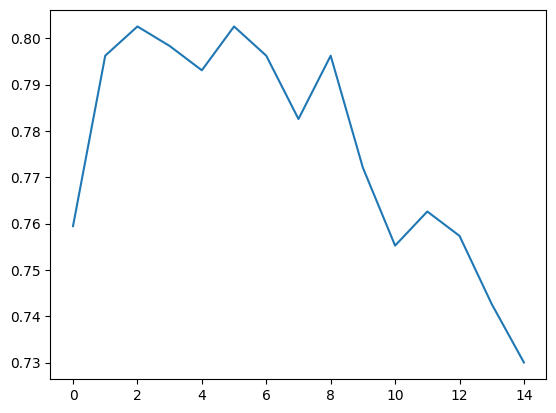

[0.759453781512605, 0.7962184873949579, 0.8025210084033614, 0.7983193277310925, 0.7930672268907563, 0.8025210084033614, 0.7962184873949579, 0.782563025210084, 0.7962184873949579, 0.7720588235294118, 0.7552521008403361, 0.7626050420168067, 0.7573529411764706, 0.7426470588235294, 0.7300420168067226]
Accuracy наилучшей модели 'Решающее дерево' на валидационной выборке: 0.8025210084033614 при max_depth = 2


In [26]:
start_time = time.time()
hist = np.array(np.empty([0]))
# Объявим список значений accuracy
accuracy_list = []
for depth in range(1, 16):
    # определяем вид модели и ее гиперпараметры
    dtc = DecisionTreeClassifier(random_state=RANDOM_FIX_NUMBER, max_depth=depth)    
    # обучаем модель на обучающем наборе данных
    dtc.fit(features_train, target_train)    
    # находим предсказания модели на валидационной выборке
    predictions_valid = dtc.predict(features_valid)    
    # посчитаем метрику accuracy, используя в качестве ответов целевой признак валидационного набора
    result = accuracy_score(target_valid, predictions_valid)
    accuracy_list.append(result)
    # вывод на график
    clear_output(wait=True)
    hist = np.append(hist, result)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()
print(accuracy_list)
print("Accuracy наилучшей модели 'Решающее дерево' на валидационной выборке:",
      max(accuracy_list), 'при max_depth =', np.argmax(accuracy_list))
elapsed_time = round(time.time() - start_time, 2)

Нашли лучший вариант - при глубине дерева 3 доля правильных ответов составляет 78%.

Как видим при глубине дерева более 12 доля правильных ответов падает, что свидетельствует о перееобучаемости модели.

Создадим датафрейм results_df, в котором, для каждой изучаемой модели, будем записывать значение accuracy, лучшие параметры модели и вермя расчета:

In [27]:
dict = {'model': ['Модель "Решающее дерево"'],
        'programm':['DecisionTreeClassifier'],
        'accuracy':[max(accuracy_list)],
        'max_depth': [np.argmax(accuracy_list)],
        'n_estimators':[''],
        'CPU times, ms': [elapsed_time]
       }
df_results = pd.DataFrame(dict)
df_results

,model,programm,accuracy,max_depth,n_estimators,"CPU times, ms"
0,"Модель ""Решающее дерево""",DecisionTreeClassifier,0.802521,2,,1.41


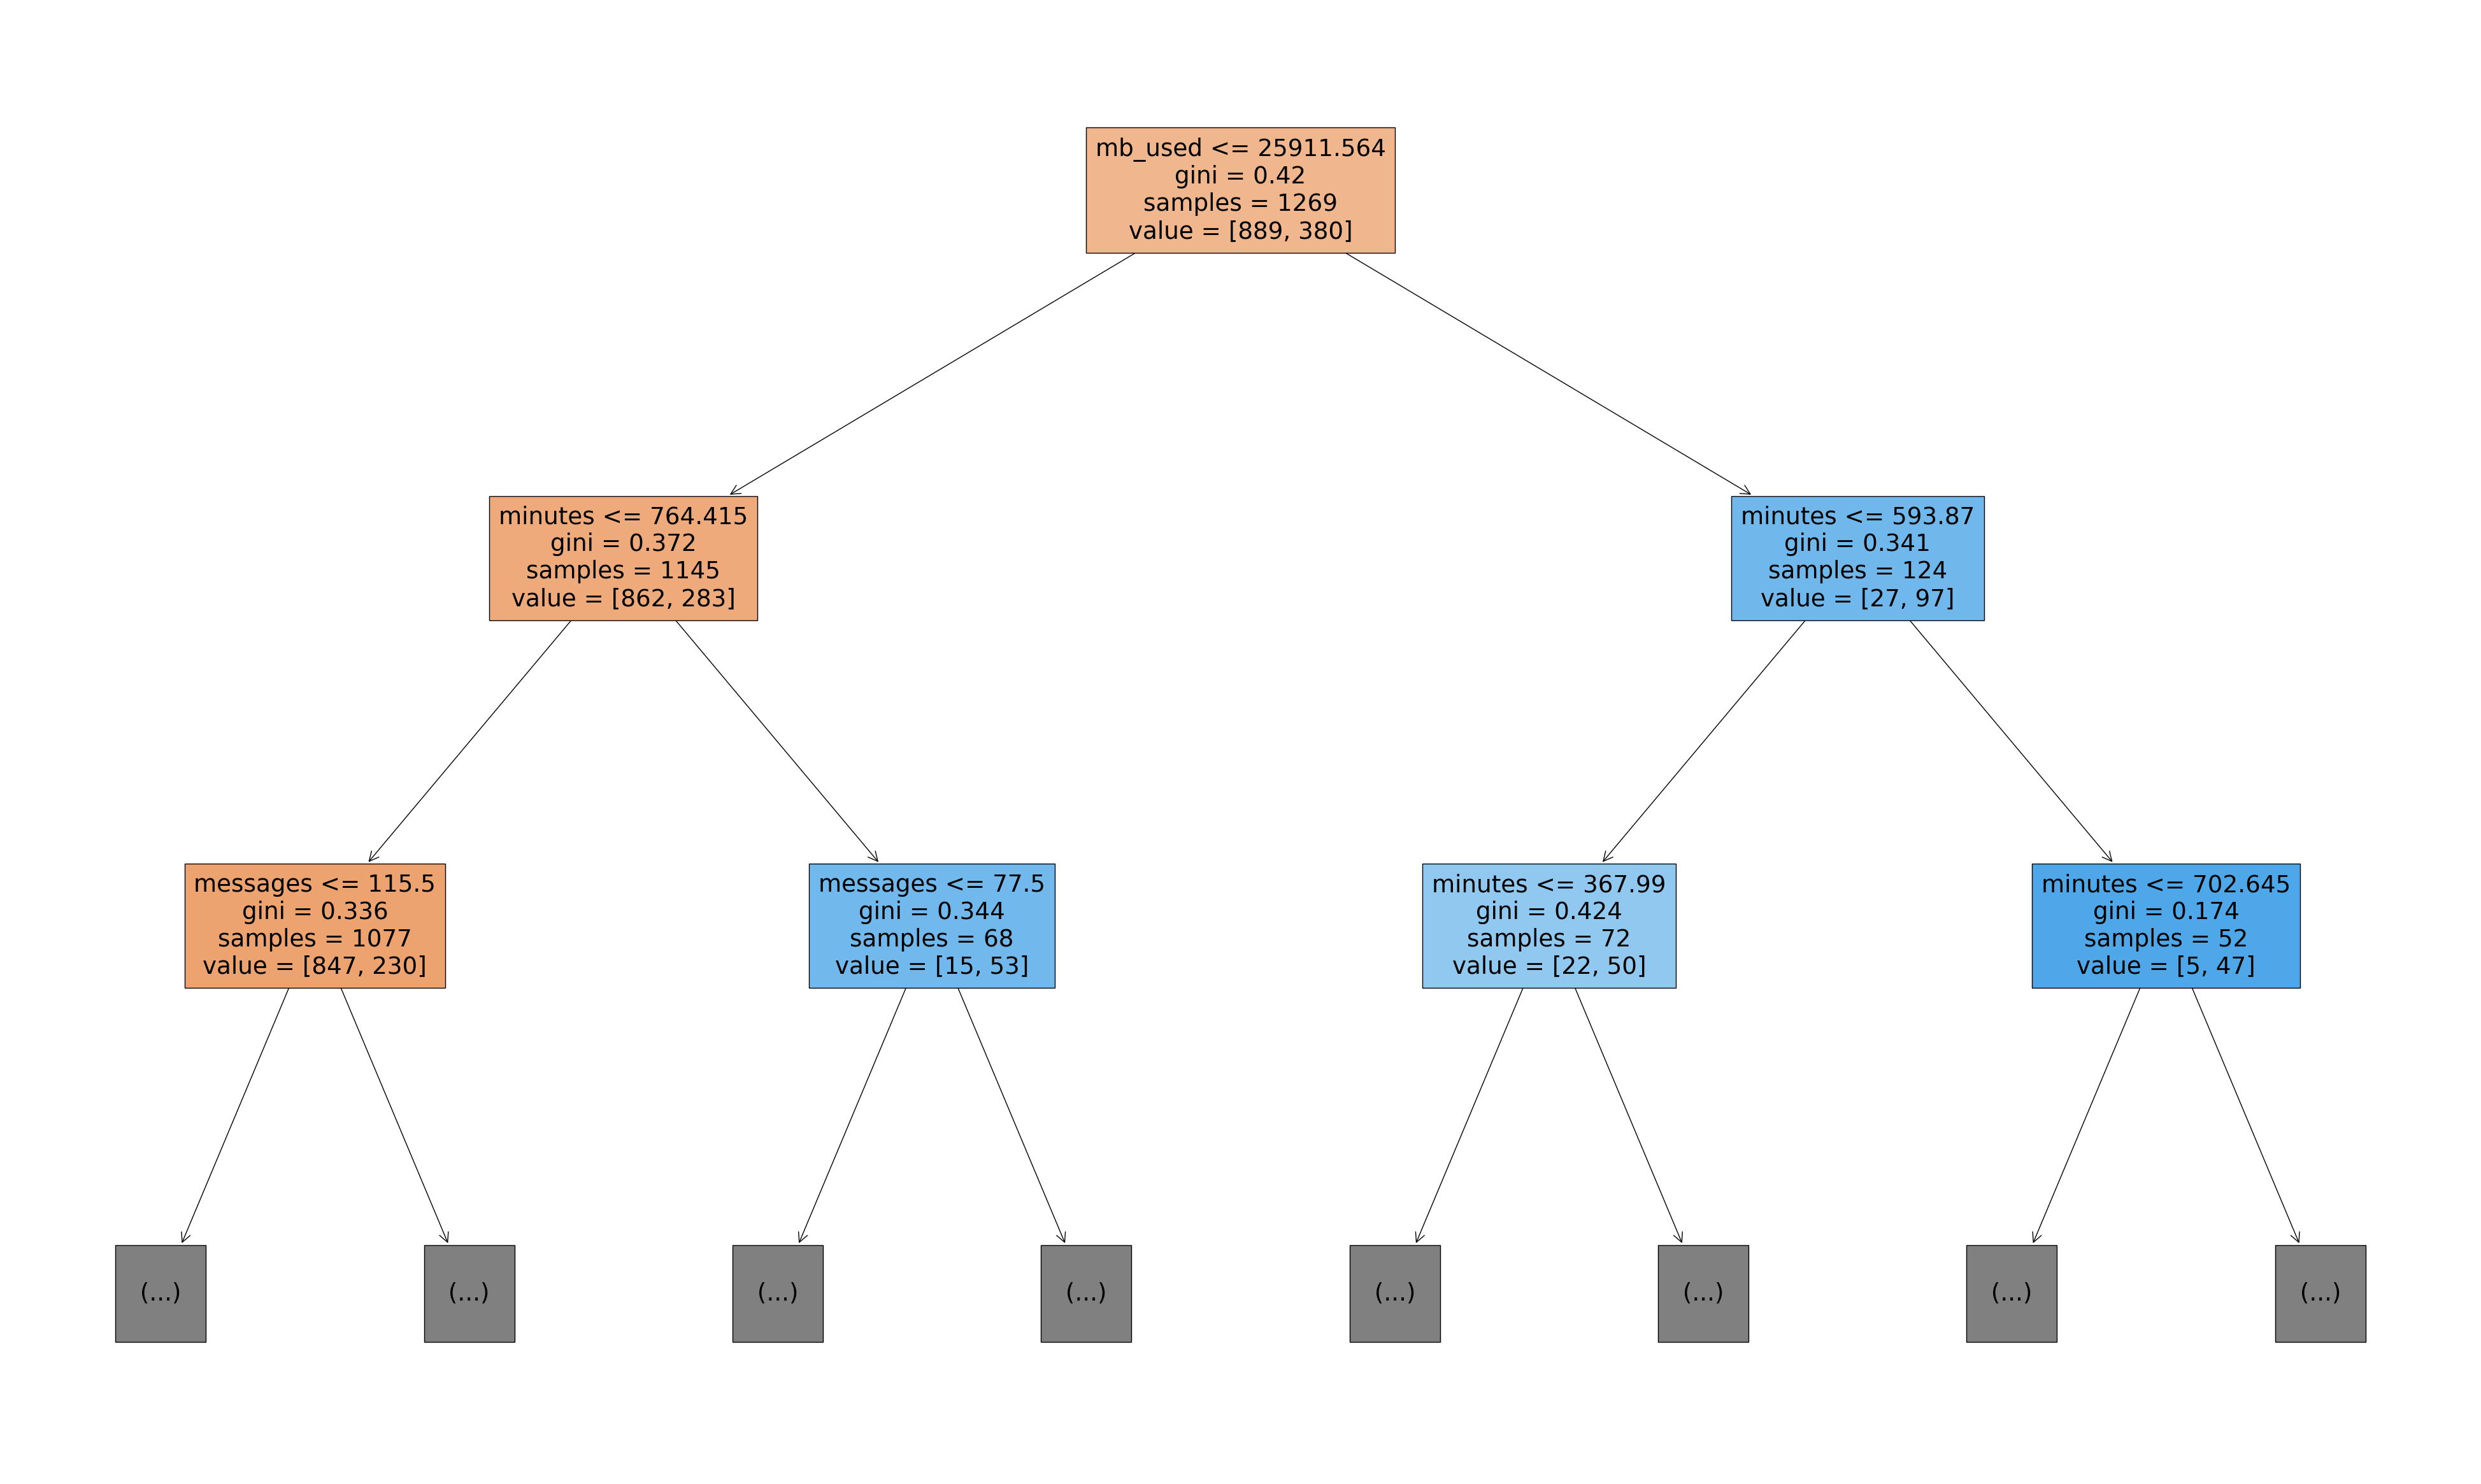

In [28]:
# Примечание:
# Отметим графические возможности анализа дерева с использованием объекта tree_plot.
# На примере DecisionTreeClassifier глубиной max_depth=3 (глубже уже не будет так наглядно) можно глянуть как DT сплиты делает,
# будет понимание как модель принимает решения: какие признаки использует, на каких значениях делает разбиение вправо-влево.
dtc = DecisionTreeClassifier(random_state=RANDOM_FIX_NUMBER, max_depth=3)
dtc.fit(features_train, target_train)
# построим первые ветки plot_tree
plt.figure(figsize=(50, 30))
plot_tree(dtc, feature_names=list(features_train.columns), filled = True, max_depth=2)
plt.title('')
plt.show()

Примечание:
Если вкратце, то на нём изображены сплиты, модель берет признак и смотрит больше или меньше какого-то числа и относит вправо или влево. Values - там 2 цифры, это сколько обьектов (на train) попали при таких сплитах с лейблом 0 и 1, чем выше доля одного из них, тем синей или коричневей ячейка. А 'gini' - это то что мы минимизируем, если в какой-то ячейки окажутся объекты только одного класса, то это будет означает минимальную энтропию (то есть Джинни будет 0).

## Модель "Случайный лес"

В модели "Случайный лес" применим два цикла.
Первый цикл будет перебирать глубину дерева max_depth, а второй для каждой глубины дерева будет перебирать количества деревьев n_estimators.

In [29]:

start_time = time.time()
best_model = None
best_result = 0
for depth in range(1, 16):
    for est in tqdm(range(3,33)):
        # модель с заданными глубиной и количеством деревьев
        rfc = RandomForestClassifier(random_state=RANDOM_FIX_NUMBER, max_depth=depth, n_estimators=est)
        # обучим модель на тренировочной выборке
        rfc.fit(features_train, target_train)
        # посчитаем качество модели на валидационной выборке
        result = rfc.score(features_valid, target_valid)
        if result > best_result:
            best_result = result # наилучшее значение метрики accuracy
            best_depth = depth # глубина
            best_est = est # количество деревьев
            best_model = rfc # наилучшая модель на валидационных данных
elapsed_time = round(time.time() - start_time, 2)
print("Accuracy наилучшей модели 'Случайный лес' на валидационной выборке:", best_result)
print("Глубина:", best_depth)
print("Количество деревьев:", best_est)

100%|██████████| 30/30 [00:01<00:00, 17.88it/s]

Accuracy наилучшей модели 'Случайный лес' на валидационной выборке: 0.8256302521008403
Глубина: 11
Количество деревьев: 19


In [30]:
df_results.loc[len(df_results.index)] = {'model': 'Модель "Случайный лес"',
        'programm':'RandomForestClassifier',
        'accuracy':best_result,
        'max_depth': best_depth,
        'n_estimators':best_est,
        'CPU times, ms': elapsed_time
       }
df_results

,model,programm,accuracy,max_depth,n_estimators,"CPU times, ms"
0,"Модель ""Решающее дерево""",DecisionTreeClassifier,0.802521,2,,1.41
1,"Модель ""Случайный лес""",RandomForestClassifier,0.825630,11,19,18.31


Самый лучший результат получили при глубине дерева 11 и количестве деревьев 19. Доля правильных ответов составляет 82%.

## Модель "Логистическая регрессия"

In [31]:
start_time = time.time()
lr = LogisticRegression(random_state=RANDOM_FIX_NUMBER, solver='lbfgs', max_iter=1000)
lr.fit(features_train, target_train)
predict = lr.predict(features_valid)
result = accuracy_score(target_valid, predict)
elapsed_time = round(time.time() - start_time, 2)
print("Accuracy модели 'Логистическая регрессия' на валидационной выборке:", result)

Accuracy модели 'Логистическая регрессия' на валидационной выборке: 0.7636554621848739


Модель логистической регрессии показывает самый худший результат, 76% правильных ответов.

## Итоговая таблица оценки `accuracy`

In [32]:
df_results.loc[len(df_results.index)] = {'model': 'Модель "Логистическая регрессия"',
        'programm':'LogisticRegression',
        'accuracy':result,
        'max_depth': '',
        'n_estimators':'',
        'CPU times, ms': elapsed_time
       }
df_results

,model,programm,accuracy,max_depth,n_estimators,"CPU times, ms"
0,"Модель ""Решающее дерево""",DecisionTreeClassifier,0.802521,2,,1.41
1,"Модель ""Случайный лес""",RandomForestClassifier,0.825630,11,19,18.31
2,"Модель ""Логистическая регрессия""",LogisticRegression,0.763655,,,0.01


## Проверка качества модели на тестовой выборке

Проверим как ведет себя наилучшая модель "Случайный лес" на тестовой выборке.

In [33]:
predictions_rf_test = best_model.predict(features_test)
accuracy_rf_test = accuracy_score(target_test, predictions_rf_test)
accuracy_rf_test

0.7859391395592865

79% правильных ответов.

Попробуем поднять точность модели путем обучения на тренировочном + валидационном наборе данных.

In [34]:
# Объединим датасеты
target_merged = pd.concat([target_train, target_valid], axis=0)
features_merged = pd.concat([features_train, features_valid], axis=0)
target_merged.shape, features_merged.shape

((2221,), (2221, 3))

In [35]:
# Обучаем на features_merged
best_model.fit(features_merged, target_merged)
# Делаем прогноз на features_test
predictions_merged = best_model.predict(features_test)
accuracy_merged = accuracy_score(target_test, predictions_merged)
accuracy_merged

0.7932843651626443

80% - точность стала лучше.

Посмотрим на еще несколько метрик этой модели, а именно: precision, recall, F1 и confussion matrix.

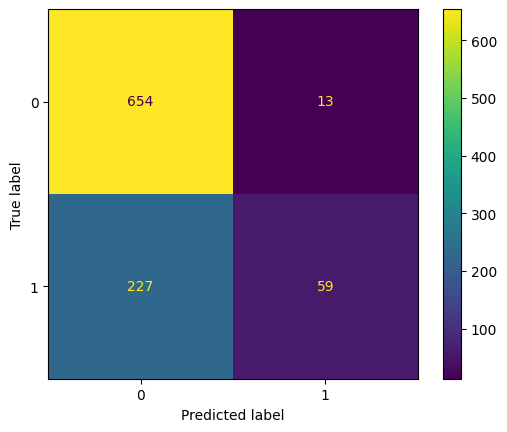

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# Примечание: confusion_matrix - показывает, насколько хорошо модель классифицирует новые примеры,
# которые были добавлены в набор данных после того, как модель уже была обучена на предыдущих примерах.
# Истинно положительный результат (TP), Ложноотрицательный результат (FN)
# Ложноположительный результат (FP), Истинное отрицание (TN)
# В колонках "Прогноз", в строках "Факт":
# [[TP, FN],
# [FF, FN]]
from sklearn.metrics import confusion_matrix as confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as ConfusionMatrixDisplay
from sklearn.svm import SVC as SVC

clf = SVC(random_state=0)
clf.fit(features_merged, target_merged)
SVC(random_state=0)
predictions = clf.predict(features_test)
cm = confusion_matrix(target_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# Наилучшее значение равно 1, а наихудшее - 0.
from sklearn.metrics import precision_score as precision_score
precision_score = precision_score(target_test, predictions_merged)
print(f"{precision_score = :.4f}")

precision_score = 0.7282


In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# Наилучшее значение равно 1, а наихудшее - 0.
from sklearn.metrics import recall_score as recall_score
recall_score = recall_score(target_test, predictions_merged)
print(f"{recall_score = :.4f}")

recall_score = 0.4965


In [39]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# Наилучшее значение равно 1, а наихудшее - 0.
from sklearn.metrics import f1_score as f1_score
f1_score = f1_score(target_test, predictions_merged)
f1_score
print(f"{f1_score = :.4f}")

f1_score = 0.5904


Таким образом, наша модель сможет предсказать подходящий тариф клиенту с точностью 0.80%.
Имея такую модель, можно предложить клиентам:
- перейти на более оптимальный тариф (если тариф клиента не соответствуют предсказанному).
- новым клиентам обоснованно предлагать оптимальный тариф (предсказанный моделью на основе потребностей клиента по признакам: суммарная длительность звонков в минутах, количество sms-сообщений, израсходованный интернет-трафик в Мб).

## (бонус) Проверьте модели на адекватность

Всегда необходимо проверять модель адекватность. Делается это для того, чтобы знать, что наша построенная модель работает лучше случайных предсказаний. Иначе зачем она нужна.

Сравним точность наивного прогноза самого частого класса и точность нашей модели.

In [40]:
from sklearn.dummy import DummyClassifier as DummyClassifier
# задаем константную модель, которая будет предсказывать по most_frequent - самый частый класс
dummy_clf_correct = DummyClassifier(strategy='most_frequent', random_state=RANDOM_FIX_NUMBER)
# модель смотрит на самый частый класс в target_merged и обучается
dummy_clf_correct.fit(features_merged, target_merged)
# модель прогнозирует самый частый класс в features_test
dummy_clf_correct.predict(features_test)
# считаем score
dummy_accuracy = dummy_clf_correct.score(features_test, target_test)
print(f"{dummy_accuracy = :.2f}")

dummy_accuracy = 0.70


В целевом признаке у нас дисбаланс - доля нулей в таргете 70%, то есть нули встречаются гораздо чаще единичек! Это означает, что не проводя никакого анализа, моделирования и т.п., можем постоянно предсказывать 0 и получить точность около 70%!

Примечание:

Тут логика такая - у нас есть данные и мы видим, что доля нулей в таргете около 70%, это значит что мы не проводя никакого анализа, моделирования и т.п., можем постоянно предсказывать 0 и получить точность около 70%. Вот эту accuracy в 70% новая модель должна побить, иначе окажется что наша модель не лучше наивного прогноза самого частого класса.

Вывод: Точность модели 70% меньше, чем точность нашей модели, равная 80%.

## Вывод

Мы рассмотрели три модели: "Решающее дерево", "Случайный лес" и "Логистическая регрессия". В каждой модели, изменяя ее гиперпараметры, мы нашли нашли лучший вариант с наибольшим количеством правильных ответов. Путем простого сравнения лучших моделей по доле правильных ответов определили, что для нашей задачи подходит модель "Случайного леса" с гиперпараметрами глубина дерева 6 и количество деревьев 16.

Сравнив нашу модель со случайными предсказаниями и оценив ее качество на тестовом наборе данных (результат составил 82% правильных ответов) мы подтвердили, что наша модель подходит для задачи заказчика. Таким образом можно использовать данную модель для предложения клиентам заказчика нового тарифа ("Смарт" или "Ультра").

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
